# Tax Calculations
⚠️ Fair possibility of methodological flaw

⚠️ Only considering surface lots

In [1]:
import osmnx as ox
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
ox.config(use_cache=False)
ox.__version__

'0.15.1'

## Load Tax Roll/Parcel Data and Zoning Maps

Load in all the [parcels on the tax roll](https://webgis.providenceri.gov/server/rest/services/Tax/Parcels/MapServer), and set to the correct CRS. This file was prepared in QGIS, in the `tax-data/Downtown Tax Parcels.qgz` file.

In [2]:
parcels = gpd.read_file("tax-data/Downtown-Parcels.geojson").to_crs(26919)

Let's take a look at what's in that file:

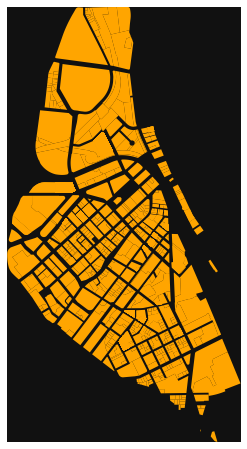

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6e788ed50>)

In [3]:
ox.plot_footprints(parcels)

Now, let's clean up that data by dropping/renaming some columns:

In [4]:
def makePLU(p):
    if p['CAMAExtract_PlatNum'] == None:
        return None
    u = p['CAMAExtract_UnitNum'].strip()
    if u == '':
        u = '0000'
    elif u.isdigit():
        u = "{:04d}".format(int(u))
    return '{}-{}-{}'.format("{:03d}".format(int(p['CAMAExtract_PlatNum'])), "{:04d}".format(int(p['CAMAExtract_LotNum'])), u)
        
parcels['plu'] = parcels.apply(lambda x: makePLU(x.to_dict()), axis=1)
    
parcels = parcels[['OBJECTID', 'plu', 'CAMAExtract_AssessedValueTotal',
       'CAMAExtract_AssessedValueLand', 'CAMAExtract_AssessedValueBuildi',
       'CAMAExtract_MuniUseCodeDesc',
       'geometry']]
parcels = parcels.rename(columns={'OBJECTID': "ParcelID", 'CAMAExtract_AssessedValueTotal': "ValueTotal", 'CAMAExtract_AssessedValueLand': "ValueLand", 'CAMAExtract_AssessedValueBuildi': "ValueBuilding", 'CAMAExtract_MuniUseCodeDesc': "Use"})

Now, we have:

In [5]:
parcels.head()

,ParcelID,plu,ValueTotal,ValueLand,ValueBuilding,Use,geometry
0,256,012-0033-0000,384100.0,384100.0,0.0,State Land Res,"MULTIPOLYGON (((300059.679 4633165.648, 300059..."
1,270,012-0031-0000,383700.0,383700.0,0.0,Mun Lnd Com,"MULTIPOLYGON (((300055.481 4633173.780, 300055..."
2,642,012-0001-REVO,14955400.0,1628700.0,13130600.0,School (94),"MULTIPOLYGON (((299938.870 4633415.808, 299954..."
3,3551,012-0470-0000,8707300.0,1228100.0,7286800.0,Public School,"MULTIPOLYGON (((300185.943 4632942.488, 300148..."
4,3597,012-0073-0000,6178400.0,1351800.0,4605600.0,Office,"MULTIPOLYGON (((300160.178 4632979.200, 300122..."


The parcels include some `'Paid Prkg Lot'`s, which have assessed values. We will separate out these entries from all others:

In [6]:
parcelsParking = parcels[parcels['Use'] == 'Paid Prkg Lot']
parcelsOther = parcels[parcels['Use'] != 'Paid Prkg Lot']

Now, load in the zoning information. This has been downloaded from Providence's GIS, simplifiied in QGIS.

In [7]:
zoning = gpd.read_file("tax-data/BaseZoning.geojson").to_crs(26919)
zoning = zoning[['Code', 'geometry']].rename(columns={'Code':'Zoning'})
zoning.head()

,Zoning,geometry
0,C-2,"MULTIPOLYGON (((300072.341 4633055.717, 300103..."
1,I-2,"MULTIPOLYGON (((300254.981 4632772.076, 300250..."
2,M-2,"MULTIPOLYGON (((300747.992 4629861.719, 300766..."
3,D-1-75,"MULTIPOLYGON (((299745.800 4633868.862, 299747..."
4,D-1-200,"MULTIPOLYGON (((299847.010 4633446.895, 299870..."


## Download Surface Parking from OSM

See `make.ipynb` for more details on this process.

In [8]:
place = "Downtown, Providence, RI, USA"

footprint_type = "parking"

osm_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
osm = ox.project_gdf(osm_unprojected).to_crs(26919)
osm = osm[osm['parking'] == "surface"]

In [9]:
osm = osm[['geometry']]
osm = gpd.overlay(osm, zoning, how='intersection')

In [10]:
osm

,Zoning,geometry
0,D-1-75,"POLYGON ((299721.629 4633536.108, 299724.365 4..."
1,D-1-75,"POLYGON ((299660.825 4633466.974, 299662.401 4..."
2,D-1-200,"POLYGON ((299777.916 4633526.651, 299779.359 4..."
3,D-1-200,"POLYGON ((299732.001 4633476.288, 299732.584 4..."
4,D-1-200,"POLYGON ((299584.988 4633449.103, 299586.398 4..."
...,...,...
197,D-1-45,"POLYGON ((299279.972 4633840.562, 299277.830 4..."
198,D-1-45,"POLYGON ((299305.826 4633756.335, 299300.242 4..."
199,D-1-45,"POLYGON ((299278.443 4633781.820, 299285.686 4..."
200,I-2,"POLYGON ((300156.470 4632945.343, 300148.527 4..."


## What are we working with?

We have a list of parcels that have been assessed with values. We know for a fact that some of these are paid parking lots, as they are indicated as such. The problem, however, is that there are a lot of parking lots (especially unpaid ones) which are considered vacant land, not parking ([this one](http://gis.vgsi.com/providenceri/Parcel.aspx?Pid=33865), for example).

We have a much more detailed dataset from OSM. In the figure below, green areas are those in the OSM dataset, red areas are in the tax roll as parking lots, and orange areas are in both. Notice that there are effectively no red areas, so the paid parking parcels in the tax data are a subset of our OSM areas.

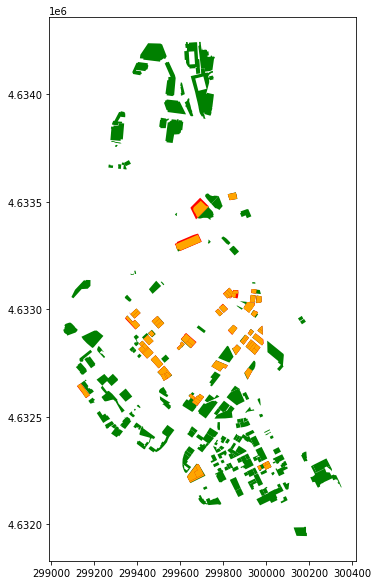

In [11]:
osm_in_parcelsParking = gpd.overlay(osm, parcelsParking, how='intersection')

ax = osm.plot(color='green', figsize=(10,10))
parcelsParking.plot(ax=ax, color='red')
osm_in_parcelsParking.plot(ax=ax, color='orange')

We can also look at all parcels that are not explicitly paid parking (yellow), OSM areas that are **not** in a parking tax roll entry (purple), and areas that are in both (blue). Note that because there is almost no purple visible, we know that almost all of the areas in OSM which are not explicitly marked as parking lots on the tax rolls are also located inside of other parcels. Very little OSM parking data is located outside of a tax roll parcel.

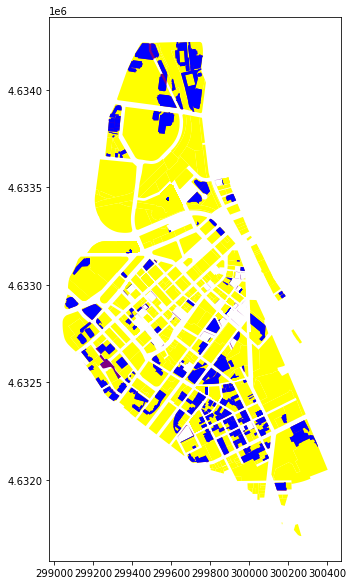

In [12]:
osm_not_parcelsParking = gpd.overlay(osm, parcelsParking, how='difference')
osm_in_parcelsOther = gpd.overlay(osm_not_parcelsParking, parcelsOther, how='intersection')

ax = parcelsOther.plot(color='yellow', figsize=(10,10))
osm_not_parcelsParking.plot(ax=ax, color='purple')
osm_in_parcelsOther.plot(ax=ax, color='blue')

## Putting it all together

### Overlaying data

First, we overlay the OSM data and Parcel data to get a list of unique Parcel IDs that contain an OSM parking area.

In [13]:
parking_parcel_ids = gpd.overlay(osm, parcels, how='intersection').ParcelID.unique()

not_parking_parcels = parcels[~(parcels['ParcelID'].isin(parking_parcel_ids))]
parking_parcels = parcels[(parcels['ParcelID'].isin(parking_parcel_ids))]

This intersection creates a lot new geometries. Some parking areas straddle multiple parcels, so here we create a new frame of "osm_parcels", where each entry refers to an area the corresponds to a unique OSM section and parcel.

In [14]:
def getParcelArea(parcelId):
    mergedGeom = shapely.ops.unary_union(parcels[parcels.ParcelID == parcelId].geometry.values)
    return mergedGeom.area

osm_parcels = gpd.overlay(osm, parcels, how='intersection')
osm_parcels['OSMArea'] = osm_parcels.geometry.apply(lambda x: x.area)
osm_parcels['ParcelArea'] = osm_parcels['ParcelID'].apply(lambda x: getParcelArea(x))

Similarly, we overlay parcels and zoning:

In [15]:
parcelsZoning = gpd.overlay(parcels, zoning, how='intersection')
parcelsZoning.head()

,ParcelID,plu,ValueTotal,ValueLand,ValueBuilding,Use,Zoning,geometry
0,256,012-0033-0000,384100.0,384100.0,0.0,State Land Res,OS,"POLYGON ((300059.679 4633165.648, 300059.675 4..."
1,270,012-0031-0000,383700.0,383700.0,0.0,Mun Lnd Com,OS,"POLYGON ((300055.481 4633173.780, 300055.477 4..."
2,3886,012-0050-00EX,25656200.0,1787000.0,23291600.0,Public School,OS,"POLYGON ((300072.699 4633055.872, 300072.350 4..."
3,3887,012-0050-00TX,3848430.0,1787000.0,1483830.0,Office,OS,"POLYGON ((300072.699 4633055.872, 300072.350 4..."
4,3985,012-0029-0000,497700.0,477700.0,0.0,Mun Lnd Com,OS,"POLYGON ((300051.177 4633182.116, 300051.174 4..."


### Value of land not used for parking

Here, we calculate that assessed value of land *not* used for parking by zoning. This will be useful later when we try to figure out what the value of a parking-only parcel *could* be if it were built to the same extent/style as other parcels in the zone in the Downtown neighborhood.

In [16]:
nonparking_values_by_zone = pd.DataFrame(columns=['zone', 'area', 'buildingValue']).set_index('zone')

for zone in parcelsZoning.Zoning.unique():
    bits = parcelsZoning[parcelsZoning['Zoning'] == zone]
    nonparking_values_by_zone.loc[zone] = (bits.geometry.area.sum(), bits.ValueBuilding.sum())
    
nonparking_values_by_zone['valuePerArea'] = nonparking_values_by_zone['buildingValue'] / nonparking_values_by_zone['area']
nonparking_values_by_zone

,area,buildingValue,valuePerArea
zone,,,
OS,2.258173e+04,2.808183e+07,1243.564074
D-1-100,6.017053e+05,5.444757e+08,904.887718
I-2,1.557855e+03,7.286800e+06,4677.457576
C-2,7.737045e+03,2.938103e+07,3797.448419
D-1-200,1.965388e+06,1.067739e+09,543.271048
D-1-120,3.276878e+05,4.376709e+08,1335.633915
M-2,6.280337e+04,2.578253e+08,4105.278354
D-1-300,4.805930e+05,5.942897e+08,1236.575847
D-1-45,9.131672e+03,3.954630e+07,4330.674437


### Area used for parking in each parcel

As mentioned, OSM areas and parcel boundaries don't line up perfectly. Here, we calculate the area of each parcel that is also an OSM parking area.

In [17]:
parkingAreas = pd.DataFrame(columns=['parcel', 'parea']).set_index('parcel')

for p in osm_parcels.ParcelID.unique():
    parkingAreas.loc[p, 'parea'] = osm_parcels[osm_parcels['ParcelID'] == p].OSMArea.sum()

### Finding "missing" values

Here, we try to find out the building value that is "missing." Most parking lots already have assessed land values, but don't have building values because there are no buildings in the lots.

If the parcel is marked as a "Paid Prkg Lot" in the tax roll or has a building value of zero, we use the parcel's zoning to assign it the average building value for that zoning in the Downtown neighborhood.

If the parcel does not meet these criteria, some building value has been assessed. We "expand" this building area into the parking area, simulating what the value might be if it occupied the entire parcel.

In [18]:
def getMissingValue(osmParcel):
    osmPercentArea = osmParcel['OSMArea'] / osmParcel['ParcelArea']
    if ((osmParcel['Use'] == "Paid Prkg Lot") | (osmParcel['ValueBuilding'] == 0)):
        return nonparking_values_by_zone.loc[osmParcel['Zoning'], 'valuePerArea'] * osmParcel['ParcelArea']
    else:
        actualEff = osmParcel['ValueBuilding'] / (osmParcel['ParcelArea'] - parkingAreas.loc[osmParcel['ParcelID'], 'parea'])
        return actualEff * osmParcel['OSMArea']

We calculate the missing percent of the valuation:

In [19]:
osm_parcels['missing_valuation'] = osm_parcels.apply(lambda x: getMissingValue(x.to_dict()), axis=1)
osm_parcels['missing_perc'] = osm_parcels['missing_valuation'] / osm_parcels['ValueTotal']

### Adding in Tax Data

Now, we add in the propper Tax Roll (2019), and add current taxes to each parcel.

In [20]:
taxes = pd.read_csv('tax-data/2019_Property_Tax_Roll.csv')
taxes.head()

,Plat-Lot-Unit,Plat,Lot,Unit,Class,Class Desc.,Levy Code,Levy Code Desc,Location Number,Location Street,...,Owner Suffix,Owner Unit,Owner City,Owner State,Owner Zip,Total Assessment,Total Exemption,Total Taxes,Property Location,Owner Location
0,028-0138-0000,28.0,138.0,0000,13.0,Residential Vacant Land,PRA,PRA,44.0,Knight,...,ST,NaN,PROVIDENCE,RI,02903-3222,123700.0,0.0,3038.08,"44 Knight St Providence, RI 02909","400 WESTMINSTER ST PROVIDENCE , RI 02903-3222"
1,028-0843-0000,28.0,843.0,0000,13.0,Residential Vacant Land,PRA,PRA,242.0,Federal,...,Ave,NaN,Providence,RI,02907,71200.0,0.0,1748.68,"242 Federal St Providence, RI 02909","151 Atlantic Ave Providence , RI 02907"
2,028-1046-0000,28.0,1046.0,0000,14.0,CI Vacant Land,PRA,PRA,20.0,America,...,AVE,NaN,PROVIDENCE,RI,02903-1632,67200.0,0.0,1650.44,"20 America St Providence, RI 02909","134 ATWELLS AVE PROVIDENCE , RI 02903-1632"
3,028-1047-0000,28.0,1047.0,0000,14.0,CI Vacant Land,PRA,PRA,24.0,America,...,AVE,NaN,NORTH PROVIDENCE,RI,02911-1809,65600.0,0.0,1611.16,"24 America St Providence, RI 02909","2010 MINERAL SPRING AVE NORTH PROVIDENCE , RI..."
4,029-0389-0000,29.0,389.0,0000,13.0,Residential Vacant Land,PRA,PRA,251.0,Pearl,...,NaN,NaN,Providence,RI,02940,2400.0,0.0,58.96,"251 Pearl St Providence, RI 02905","PO Box 40573 Providence , RI 02940"


In [21]:
def getTaxes(x):
    try:
        return (taxes[taxes['Plat-Lot-Unit'] == x]['Total Taxes'].values[0])
    except:
        return np.nan

osm_parcels['taxCurrent'] = osm_parcels['plu'].apply(lambda x: getTaxes(x))

Next, we calculate the potential taxes that could be collected for each parcel, by multiplying the percent of the valuation that is "missing" by the taxes the current valuation currently yields.

In [22]:
osm_parcels = osm_parcels.fillna(0)
osm_parcels['taxPotential'] = osm_parcels['missing_perc'] * osm_parcels['taxCurrent']

Sum these up to get:

In [23]:
osm_parcels.taxPotential.sum()

11325893.451457802